# Histopathologic Cancer Detection 

Lets just start with some imports straight away

In [12]:
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns 
from sklearn.utils import shuffle
import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adadelta
from pyspark.sql import SparkSession

logger = logging.getLogger()

## Purpose and goal definition

Our purpose is to be able to identify metastatic cancer in small image patches taken from larger digital pathology scans, specifically of lymph node sections. Both of us were highly interested in medical, preferebly brain problem, but after not finding a good enough dataset on kaggle for brain pathologies we decided to go with the Histopathologic Cancer Detection dataset which spiked our interest. 

We believe solving these groups of problems is highly important. Being able to detect cancer using an algorithem can potentially shorten detection and diagnosis times, reduce human error and subsequentially save patient lives and reduce further complications.

### So why is solving the Histopathologic Cancer Detection dataset challenge so important?
The **lymph system** is a part of our immune system. It includes a network of lymph vessels and nodes. Lymph vessels are a lot like the veins that collect and carry blood through the body. But instead of carrying blood, these vessels carry the clear watery fluid called lymph. Lymph fluid also contains white blood cells, which help fight infections.

Cancer can appear in the lymph nodes in 2 ways: 
* start there (lymphoma)
* spread there from somewhere else.

In the case of this project it doesn't matter to us if it started there or spread there, the question is, is it there or not. 

Generally speaking, cancer in lymph nodes is hard to find. Normal lymph nodes are tiny and can be hard to find as is, but when there’s any kind of infection, inflammation, or cancer, the nodes can get larger. Those near the body’s surface often get big enough to feel with your fingers, and some can even be seen. But if there are only a few cancer cells in a lymph node, it may look and feel normal. Lymph nodes deep in the body cannot be felt or seen. **Essentially the only way to know whether there is cancer in a lymph node is to do a biopsy**. 

**Histopathology** is the diagnosis and study of diseases of the tissues in order to study the manifestation of different deseases, including cancer. It involves examining tissues and cells under a microscope, **a biopsy**. Histopathologists are doctors who are responsible for that study and the diagnoses that follows, they help clinicians manage a patient's care.

As we can assume, manual detection of a cancer cell is a tiresome task and involves human error. Most parts of the cell are frequently part of irregular random and arbitrary visual angles. As we already mentioned, the only way to detect cancer in a lymph node is using a biopsy. Machine learning algorithems can be applied to obtain better results as compared with manual pathological detection systems, this means that solving this challenge can be cruicial for lymph node cancer patients.  

**The goal** is to identify whether a tumor is benign or of a malignant in nature, malignant tumors are cancerous, which means they should be treated as soon as possible to reduce and prevent further complications. In other words we are dealing with a **binary classification problem**. 

### Solution evaluation

As defined by the Kaggle competition, out evaluation metric will be the area under the ROC curve between the predicted probability and the observed target, AUC. 
* **ROC** curve is a plot of True positive rate against False positive rate at various thresholds
* **AUC** is the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one

This is highly important because we are dealing with cancer tissue where a false negative can have disastrous implications. We'll be "more okay" with classifiying false positives than false negatives. In this project we'll strive to get an AUC as close to 1 as possible.

## Data collection

Data was collected directly from [Kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data). It's a slightly modified version of the PCam dataset that can be found right [here](https://github.com/basveeling/pcam). The difference between the Kaggle version and the PCam version is that the PCam version contains duplications due to it's probabalistic sampling. 

We've decided to work with Spark for preprocessing because of the time it took us to apply functions like low exposure on all of our data. Distributing it, even locally, proved to be a big help.

In [13]:
spark = SparkSession \
    .builder \
    .appName("DSProject") \
    .config("spark.executor.memory","2g") \
    .config("spark.driver.memory","6g") \
    .config("spark.driver.maxResultSize","4g") \
    .config("spark.jars.packages", "com.twelvemonkeys.imageio:imageio-tiff:3.5,com.twelvemonkeys.imageio:imageio-core:3.5") \
    .master("local[*]") \
    .getOrCreate()

:: loading settings :: url = jar:file:/Users/alexakh/Library/Python/3.8/lib/python/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/alexakh/.ivy2/cache
The jars for the packages stored in: /Users/alexakh/.ivy2/jars
com.twelvemonkeys.imageio#imageio-tiff added as a dependency
com.twelvemonkeys.imageio#imageio-core added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-05239479-c6f2-4c5c-af77-a509098633ca;1.0
	confs: [default]
	found com.twelvemonkeys.imageio#imageio-tiff;3.5 in central
	found com.twelvemonkeys.imageio#imageio-metadata;3.5 in central
	found com.twelvemonkeys.common#common-lang;3.5 in central
	found com.twelvemonkeys.common#common-io;3.5 in central
	found com.twelvemonkeys.common#common-image;3.5 in central
	found com.twelvemonkeys.imageio#imageio-core;3.5 in central
:: resolution report :: resolve 344ms :: artifacts dl 10ms
	:: modules in use:
	com.twelvemonkeys.common#common-image;3.5 from central in [default]
	com.twelvemonkeys.common#common-io;3.5 from central in [default]
	com.twelvemonkeys.common#common-lang;3.5 from central in [d

In [14]:
X_data_directory = "../../data/histopathologic-cancer-detection/train/"
y_data_directory = "../../data/histopathologic-cancer-detection/train_labels.csv"

data_to_predict_directory = "../../data/histopathologic-cancer-detection/test"

In [15]:
y_data_directory

'../../data/histopathologic-cancer-detection/train_labels.csv'

Loading tif images was not possible using Spark "image" format for us at first, the additional information that is supposed to be in the struct (like number of channels, height, width) was all -1, meaning invalid image. We later on learned that it was not possible since Spark is using ImageIO to read images, and reading tif images was made possible onnly for Java 9. We added the com.twelvemonkeys.imageio:imageio-tiff for that purpose.

In [16]:
X_df = spark.read.format("image").load(X_data_directory)

22/06/14 22:35:05 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


In [18]:
X_df.take(1)

In [19]:
X_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



Lets look at a single image reshaped innto ND array 

In [20]:
X_df.show()

+--------------------+
|               image|
+--------------------+
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
|{file:///Users/al...|
+--------------------+
only showing top 20 rows



In [13]:
X_df.take(1)[0][0][5]

In [21]:
X_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



Lets load the labels from the CSV file

In [22]:
y_df = spark.read.option("header", "true").csv(y_data_directory)

In [16]:
y_df.show(truncate=False)

+----------------------------------------+-----+
|id                                      |label|
+----------------------------------------+-----+
|f38a6374c348f90b587e046aac6079959adf3835|0    |
|c18f2d887b7ae4f6742ee445113fa1aef383ed77|1    |
|755db6279dae599ebb4d39a9123cce439965282d|0    |
|bc3f0c64fb968ff4a8bd33af6971ecae77c75e08|0    |
|068aba587a4950175d04c680d38943fd488d6a9d|0    |
|acfe80838488fae3c89bd21ade75be5c34e66be7|0    |
|a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da|1    |
|7f6ccae485af121e0b6ee733022e226ee6b0c65f|1    |
|559e55a64c9ba828f700e948f6886f4cea919261|0    |
|8eaaa7a400aa79d36c2440a4aa101cc14256cda4|0    |
|a106469bbfda4cdc5a9da7ac0152927bf1b4a92d|0    |
|c3d660212bf2a11c994e0eadff13770a9927b731|1    |
|a1991e73a9b676faddd2bd47c39754b14d1eb923|0    |
|08566ce82d4406f464c9c2a3cd014704735db7a9|0    |
|94fa32b29cc1c00403176c0795fffa3cfaa0f20e|1    |
|f416de7491a31951f79b3cee75b002f4d1bf0162|0    |
|a1c001f6b242c72d3066f15ac6eb059ea72d30ba|0    |
|0b820b71670c039dd0a

In [17]:
y_df.count()

220025

In [14]:
y_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- label: string (nullable = true)



### Sort labels in alphanumeric order

In [23]:
y_sorted_df = y_df.orderBy('id')

In [19]:
y_sorted_df.show(truncate=False)

+----------------------------------------+-----+
|id                                      |label|
+----------------------------------------+-----+
|00001b2b5609af42ab0ab276dd4cd41c3e7745b5|1    |
|000020de2aa6193f4c160e398a8edea95b1da598|0    |
|00004aab08381d25d315384d646f5ce413ea24b1|0    |
|0000d563d5cfafc4e68acb7c9829258a298d9b6a|0    |
|0000da768d06b879e5754c43e2298ce48726f722|1    |
|0000f8a4da4c286eee5cf1b0d2ab82f979989f7b|0    |
|00010f78ea8f878117500c445a658e5857f4e304|0    |
|00011545a495817817c6943583b294c900a137b8|0    |
|000126ec42770c7568204e2f6e07eb9a07d5e121|0    |
|00014e39b5df5f80df56f18a0a049d1cc6de430a|1    |
|00016a638ed77529609ac61479dc7ee99a6f3711|0    |
|0001a2bc5d4aa55989f014bfad74a95ac3dfff54|1    |
|0001b13d0d0f66d147a4167fca19fe22721556d4|0    |
|00027298de60883932506d5c46be978d71a2da68|1    |
|0002b6bb08e7520917c302addd291000b670069c|0    |
|0002d959eecbd8d7f6614fdd513154e8e0e8e964|1    |
|00030ae10b490d6f1b114bd7ea7a222889e61baa|0    |
|0003378267bd3d9964d

### Preprocess labels so we'd be able to use them for loading and visualizing images 

In [24]:
from pyspark.sql.types import IntegerType, BooleanType, DateType, StringType
from pyspark.sql.functions import lit, concat, col

In [25]:
y_trs_df = y_sorted_df.withColumn('translated_label',y_sorted_df["label"].cast(BooleanType()))

In [22]:
y_trs_df.show(truncate=False)

+----------------------------------------+-----+----------------+
|id                                      |label|translated_label|
+----------------------------------------+-----+----------------+
|00001b2b5609af42ab0ab276dd4cd41c3e7745b5|1    |true            |
|000020de2aa6193f4c160e398a8edea95b1da598|0    |false           |
|00004aab08381d25d315384d646f5ce413ea24b1|0    |false           |
|0000d563d5cfafc4e68acb7c9829258a298d9b6a|0    |false           |
|0000da768d06b879e5754c43e2298ce48726f722|1    |true            |
|0000f8a4da4c286eee5cf1b0d2ab82f979989f7b|0    |false           |
|00010f78ea8f878117500c445a658e5857f4e304|0    |false           |
|00011545a495817817c6943583b294c900a137b8|0    |false           |
|000126ec42770c7568204e2f6e07eb9a07d5e121|0    |false           |
|00014e39b5df5f80df56f18a0a049d1cc6de430a|1    |true            |
|00016a638ed77529609ac61479dc7ee99a6f3711|0    |false           |
|0001a2bc5d4aa55989f014bfad74a95ac3dfff54|1    |true            |
|0001b13d0

In [26]:
y_trs_df = y_trs_df.withColumn('file_name',concat(lit(X_data_directory),y_sorted_df["id"],lit(".tif")))

In [21]:
y_trs_df.show(truncate=False)

+----------------------------------------+-----+----------------+----------------------------------------------------------------------------------------------+
|id                                      |label|translated_label|file_name                                                                                     |
+----------------------------------------+-----+----------------+----------------------------------------------------------------------------------------------+
|00001b2b5609af42ab0ab276dd4cd41c3e7745b5|1    |true            |../../data/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif|
|000020de2aa6193f4c160e398a8edea95b1da598|0    |false           |../../data/histopathologic-cancer-detection/train/000020de2aa6193f4c160e398a8edea95b1da598.tif|
|00004aab08381d25d315384d646f5ce413ea24b1|0    |false           |../../data/histopathologic-cancer-detection/train/00004aab08381d25d315384d646f5ce413ea24b1.tif|
|0000d563d5cfafc4e68acb7c9829258a2

## Data visualization

As written in the description of the github repository a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable the design of fully-convolutional models that do not use any zero-padding, to ensure consistent behavior when applied to a whole-slide image. This essentially means that we can maybe crop the images and see how this influences accuracy. For now we'll keep the image as is.

In the original dataset the labels were balances between True and False and also contained information regarding the cancer in general (ie Is it cancerour? Is only the center canceros?). Kaggle removed that extra bit of information and in addition removed duplicates from the dataset.


In [27]:
y_sorted = y_trs_df.toPandas()

In [21]:
y_sorted.count()

id                  220025
label               220025
translated_label    220025
file_name           220025
dtype: int64

In [28]:
y_sorted.drop_duplicates()

,id,label,translated_label,file_name
0,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1,True,../../data/histopathologic-cancer-detection/tr...
1,000020de2aa6193f4c160e398a8edea95b1da598,0,False,../../data/histopathologic-cancer-detection/tr...
2,00004aab08381d25d315384d646f5ce413ea24b1,0,False,../../data/histopathologic-cancer-detection/tr...
3,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0,False,../../data/histopathologic-cancer-detection/tr...
4,0000da768d06b879e5754c43e2298ce48726f722,1,True,../../data/histopathologic-cancer-detection/tr...
...,...,...,...,...
220020,fffe6c73afcf5f5da5818fb70cb723026b172eca,0,False,../../data/histopathologic-cancer-detection/tr...
220021,fffeb3f5361ea57e728fb689e6be34d07d16ca7e,0,False,../../data/histopathologic-cancer-detection/tr...
220022,fffeca85b16452a7709d163e05a70e646782b3cc,1,True,../../data/histopathologic-cancer-detection/tr...
220023,fffeeb1297fd4e26f247af648a2a6f942dfa2e9d,1,True,../../data/histopathologic-cancer-detection/tr...


There are no duplicates based purely on image id, but this nothing about other means of image duplications.
// TODO: Check image duplications (rotated images etc)

In [29]:
y_sorted.groupby('id').filter(lambda x: len(x) > 1)

,id,label,translated_label,file_name


### Visualizing class labels distribution

<AxesSubplot:xlabel='translated_label', ylabel='count'>

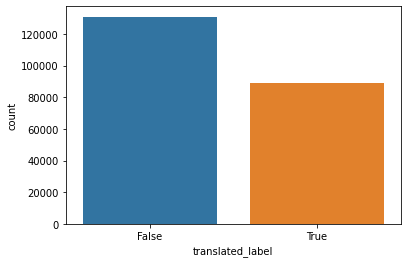

In [24]:
sns.countplot(data=y_sorted, x='translated_label')

We can see that after removing the duplications we have a bit of a skew between the labels. There are slightly more False labels than True labels. Lets look at the skew metric

In [30]:
y_sorted['label'].skew()

0.38692104417661555

We can see that the metric shows us that the labels distribution is fairly symmetrical. We'll keep it as is, and use oversampling in case we see problems with this balance in the future.

In [31]:
file_path = y_sorted.iloc[[0]]['file_name'].iloc[0]

img = plt.imread(file_path)

img.shape

(96, 96, 3)

From the shape we can see that our images are 96x96 with three color channels. Lets visualy some images and their labels. Since a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue we'll circle the 32x32 center with a patch. A blue color for negative and a red color for positive.

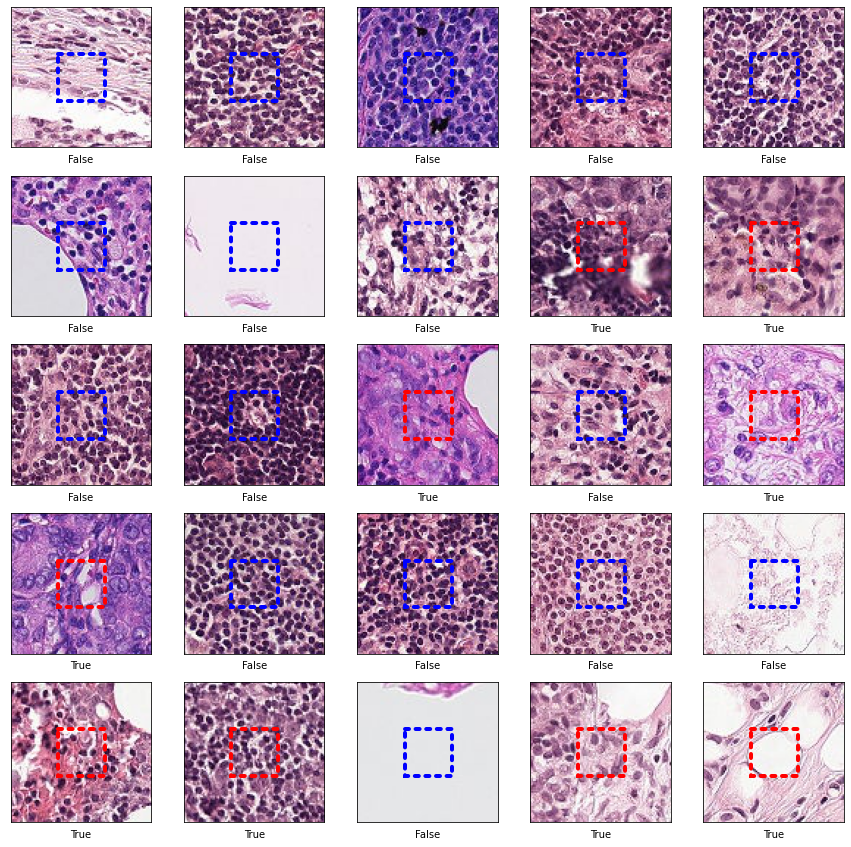

In [26]:
fig, ax = plt.subplots(5,5,figsize=(15,15))

shuffled_data = shuffle(y_sorted)

for (i,current_subplot) in zip(range(25),ax.flat):
    current_row = shuffled_data.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    curr_file_path = current_row['file_name'].iloc[0]
    
    try:
        # read image and add to plot
        img = plt.imread(curr_file_path)
        current_subplot.imshow(img)
        
        current_label = current_row['translated_label'].iloc[0]
        
        if (current_label == True):
            current_patch_color = 'r'
        else:
            current_patch_color = 'b'
        
        # create patch recatangle around the suspected area
        box = patches.Rectangle((32,32),32,32, linewidth=4, edgecolor=current_patch_color, facecolor='none', linestyle=':', capstyle='round')
        
        # add labels and patch 
        current_subplot.xaxis.label.set_text(current_row['translated_label'].iloc[0])
        current_subplot.add_patch(box)
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()


### Exploring image pixel values distribution

In [22]:
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType

from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import DenseVector, VectorUDT, SparseVector, Matrix, DenseMatrix

Lets join the images and label to one dataframe to be able to make the visualization work a little bit easier

In [23]:
X_df = X_df.withColumn("id", F.split(F.reverse(F.split("image.origin", '/'))[0],'.tif')[0])

In [24]:
data_df = X_df.join(y_trs_df, on=["id"], how="left")

In [25]:
data_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- label: string (nullable = true)
 |-- translated_label: boolean (nullable = true)
 |-- file_name: string (nullable = true)



Lets look at a single image in the spark data frame converted to ND Array. It's indeed 96x96x3 

In [26]:
ImageSchema.toNDArray(data_df.select("image").take(1)[0][0]).shape

(96, 96, 3)

We'll create a udf for each color channel. Since the behind the scene spark is using OpenCV, the color channel order in BGR and not RGB.

In [79]:
img2ndarray_red = F.udf(lambda x: DenseVector(ImageSchema.toNDArray(x)[:,:,0].flatten()), VectorUDT())
img2ndarray_green = F.udf(lambda x: DenseVector(ImageSchema.toNDArray(x)[:,:,1].flatten()), VectorUDT())
img2ndarray_blue = F.udf(lambda x: DenseVector(ImageSchema.toNDArray(x)[:,:,2].flatten()), VectorUDT())
img2ndarray_all = F.udf(lambda x: DenseVector(ImageSchema.toNDArray(x).flatten()), VectorUDT())
img2ndarray_mean_overall = F.udf(lambda x: float(np.mean(ImageSchema.toNDArray(x),axis=(0,1,2))), FloatType())

In [80]:
data_df = data_df.withColumn('red_distribution',img2ndarray_red("image")) \
                 .withColumn('green_distribution',img2ndarray_green("image")) \
                 .withColumn('blue_distribution',img2ndarray_blue("image")) \
                 .withColumn('all_distribution',img2ndarray_all("image")) \
                 .withColumn('mean_brightness', img2ndarray_mean_overall("image"))

In [81]:
data_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- label: string (nullable = true)
 |-- translated_label: boolean (nullable = true)
 |-- file_name: string (nullable = true)
 |-- red_distribution: vector (nullable = true)
 |-- green_distribution: vector (nullable = true)
 |-- blue_distribution: vector (nullable = true)
 |-- mean_brightness: float (nullable = true)
 |-- all_distribution: vector (nullable = true)



In [82]:
red_limit_true = data_df.limit(10000).where("translated_label = 'True'").select('red_distribution').toPandas()

22/06/14 12:41:52 WARN TransportChannelHandler: Exception in connection from /10.146.27.135:57127
java.io.IOException: Operation timed out
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:378)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:253)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:719)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:655)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.jav

22/06/14 12:44:32 ERROR RetryingBlockTransferor: Exception while beginning fetch of 1 outstanding blocks (after 2 retries)
java.io.IOException: Failed to connect to /10.146.27.135:57127
	at org.apache.spark.network.client.TransportClientFactory.createClient(TransportClientFactory.java:288)
	at org.apache.spark.network.client.TransportClientFactory.createClient(TransportClientFactory.java:218)
	at org.apache.spark.network.netty.NettyBlockTransferService$$anon$2.createAndStart(NettyBlockTransferService.scala:126)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.transferAllOutstanding(RetryingBlockTransferor.java:154)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.lambda$initiateRetry$0(RetryingBlockTransferor.java:184)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.T

Py4JJavaError: An error occurred while calling o415.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 28.0 failed 1 times, most recent failure: Lost task 0.0 in stage 28.0 (TID 41361) (10.146.27.135 executor driver): TaskResultLost (result lost from block manager)
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollectIterator(SparkPlan.scala:401)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec.$anonfun$relationFuture$1(BroadcastExchangeExec.scala:137)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$1(SQLExecution.scala:185)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)


In [ ]:
plt.hist(red_limit_true.flatten(),bins=255,density=True)

Split the data into positive and negative labels for comparing purposes

(array([7.50886400e-06, 1.12632816e-05, 1.12633104e-05, 3.00354177e-05,
        2.62809905e-05, 6.00709887e-05, 4.88075537e-05, 1.76458079e-04,
        1.46423035e-04, 2.44037769e-04, 2.96599750e-04, 3.56671495e-04,
        5.18110955e-04, 7.84675287e-04, 1.19015646e-03, 1.53180630e-03,
        1.79461621e-03, 2.16255559e-03, 2.69192431e-03, 3.32642251e-03,
        4.40770880e-03, 5.53778014e-03, 7.49008229e-03, 8.35735497e-03,
        8.77036435e-03, 1.08390590e-02, 1.18752230e-02, 1.30166324e-02,
        1.29603158e-02, 1.30916543e-02, 1.38388540e-02, 1.43607207e-02,
        1.45145785e-02, 1.37299754e-02, 1.31705643e-02, 1.33394458e-02,
        1.37975552e-02, 1.33545317e-02, 1.20742071e-02, 1.14510322e-02,
        1.16875617e-02, 1.10267246e-02, 1.00618906e-02, 7.97817819e-03,
        6.75044289e-03, 5.45895110e-03, 5.18487721e-03, 4.55786300e-03,
        3.68685693e-03, 3.68685693e-03, 3.11241221e-03, 2.67315900e-03,
        2.20009996e-03, 2.00110460e-03, 1.80588410e-03, 1.914762

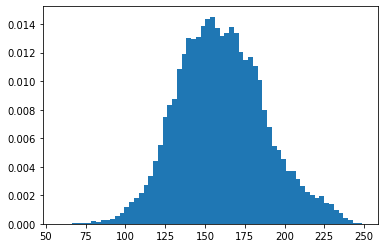

In [43]:
mean_brightness_true_pd = data_df.where("translated_label = 'True'").select("mean_brightness").toPandas()
mean_brightness_false_pd = data_df.where("translated_label = 'False'").select("mean_brightness").toPandas()

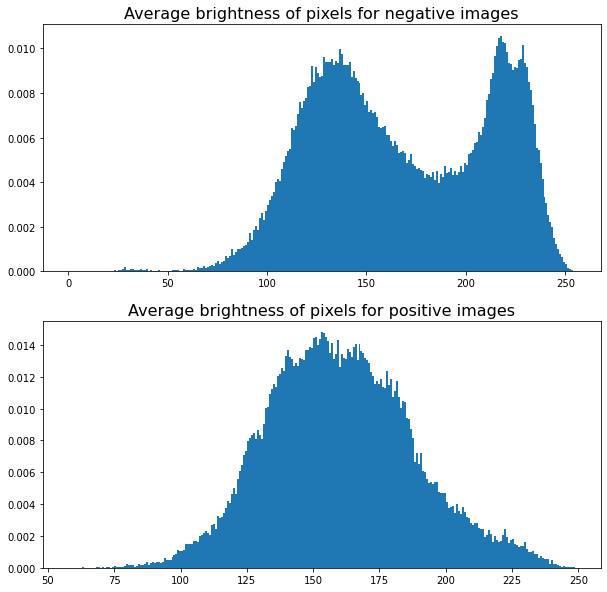

In [77]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].hist(mean_brightness_false_pd,bins=255,density=True)
ax[1].hist(mean_brightness_true_pd,bins=255,density=True)

ax[0].set_title("Average brightness of pixels for negative images", fontsize=16)
ax[1].set_title("Average brightness of pixels for positive images", fontsize=16)

plt.show()

### Exploring low/high contract images

In [32]:
from skimage.exposure import is_low_contrast

In [33]:
def is_low_contrast_func(file_name):
    return bool(is_low_contrast(plt.imread(file_name), fraction_threshold=0.3))

In [34]:
y_trs_df.show()

+--------------------+-----+----------------+--------------------+
|                  id|label|translated_label|           file_name|
+--------------------+-----+----------------+--------------------+
|00001b2b5609af42a...|    1|            true|../../data/histop...|
|000020de2aa6193f4...|    0|           false|../../data/histop...|
|00004aab08381d25d...|    0|           false|../../data/histop...|
|0000d563d5cfafc4e...|    0|           false|../../data/histop...|
|0000da768d06b879e...|    1|            true|../../data/histop...|
|0000f8a4da4c286ee...|    0|           false|../../data/histop...|
|00010f78ea8f87811...|    0|           false|../../data/histop...|
|00011545a49581781...|    0|           false|../../data/histop...|
|000126ec42770c756...|    0|           false|../../data/histop...|
|00014e39b5df5f80d...|    1|            true|../../data/histop...|
|00016a638ed775296...|    0|           false|../../data/histop...|
|0001a2bc5d4aa5598...|    1|            true|../../data/histop

In [35]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType
isLowContrastUDF = udf(lambda file_name: is_low_contrast_func(file_name),BooleanType())

In [36]:
y_low_contrast_df = y_trs_df.withColumn('is_low_contrast', isLowContrastUDF('file_name'))

In [37]:
y_low_contrast_df.persist()

DataFrame[id: string, label: string, translated_label: boolean, file_name: string, is_low_contrast: boolean]

In [38]:
y_low_contrast_df.show()

+--------------------+-----+----------------+--------------------+---------------+
|                  id|label|translated_label|           file_name|is_low_contrast|
+--------------------+-----+----------------+--------------------+---------------+
|00001b2b5609af42a...|    1|            true|../../data/histop...|          false|
|000020de2aa6193f4...|    0|           false|../../data/histop...|          false|
|00004aab08381d25d...|    0|           false|../../data/histop...|          false|
|0000d563d5cfafc4e...|    0|           false|../../data/histop...|          false|
|0000da768d06b879e...|    1|            true|../../data/histop...|          false|
|0000f8a4da4c286ee...|    0|           false|../../data/histop...|          false|
|00010f78ea8f87811...|    0|           false|../../data/histop...|          false|
|00011545a49581781...|    0|           false|../../data/histop...|           true|
|000126ec42770c756...|    0|           false|../../data/histop...|          false|
|000

In [39]:
y_to_plot = y_low_contrast_df.toPandas()

<AxesSubplot:xlabel='is_low_contrast', ylabel='count'>

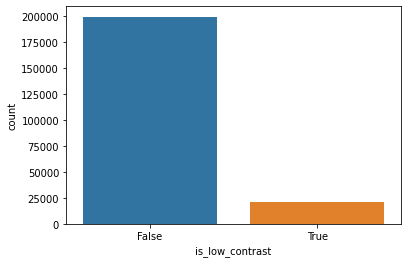

In [27]:
sns.countplot(data=y_to_plot, x='is_low_contrast')

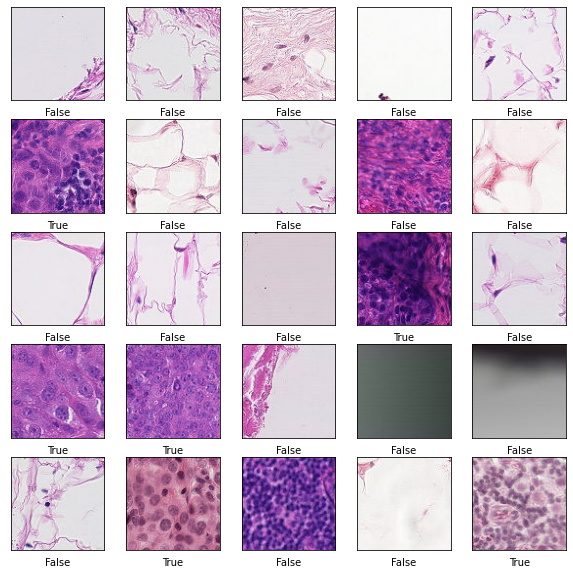

In [59]:
plt.figure(figsize=(10,10))

shuffled_low_contrast = shuffle(y_to_plot[y_to_plot["is_low_contrast"] == True])

for i in range(25):
    current_row = shuffled_low_contrast.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    curr_file_path = current_row['file_name'].iloc[0]
    
    try:
        img = plt.imread(curr_file_path)
        plt.imshow(img)

        plt.xlabel(current_row['translated_label'].iloc[0])
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

To the naked eye it seems that the threshold of 0.3 is too high. Let's try lowering that threshold.

In [40]:
def is_low_contrast_func_01(file_name):
    return bool(is_low_contrast(plt.imread(file_name), fraction_threshold=0.05))

In [41]:
isLowContrastUDF = udf(lambda file_name: is_low_contrast_func_01(file_name),BooleanType())

In [42]:
y_low_contrast_df = y_trs_df.withColumn('is_low_contrast', isLowContrastUDF('file_name'))

In [43]:
y_low_contrast_df.persist()

DataFrame[id: string, label: string, translated_label: boolean, file_name: string, is_low_contrast: boolean]

In [44]:
y_low_contrast_df.show()

+--------------------+-----+----------------+--------------------+---------------+
|                  id|label|translated_label|           file_name|is_low_contrast|
+--------------------+-----+----------------+--------------------+---------------+
|00001b2b5609af42a...|    1|            true|../../data/histop...|          false|
|000020de2aa6193f4...|    0|           false|../../data/histop...|          false|
|00004aab08381d25d...|    0|           false|../../data/histop...|          false|
|0000d563d5cfafc4e...|    0|           false|../../data/histop...|          false|
|0000da768d06b879e...|    1|            true|../../data/histop...|          false|
|0000f8a4da4c286ee...|    0|           false|../../data/histop...|          false|
|00010f78ea8f87811...|    0|           false|../../data/histop...|          false|
|00011545a49581781...|    0|           false|../../data/histop...|          false|
|000126ec42770c756...|    0|           false|../../data/histop...|          false|
|000

In [45]:
y_to_plot = y_low_contrast_df.toPandas()

<AxesSubplot:xlabel='is_low_contrast', ylabel='count'>

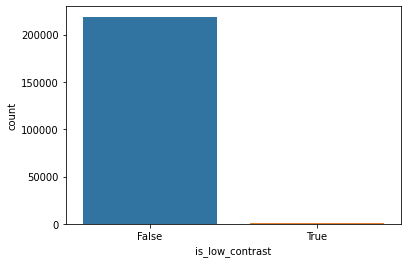

In [84]:
sns.countplot(data=y_to_plot, x='is_low_contrast')

In [46]:
y_to_plot.groupby(['is_low_contrast']).count()

,id,label,translated_label,file_name
is_low_contrast,,,,
False,218888,218888,218888,218888
True,1137,1137,1137,1137


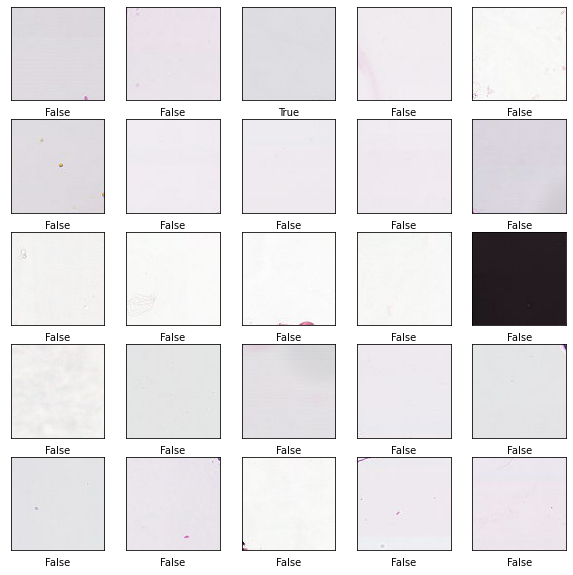

In [86]:
plt.figure(figsize=(10,10))

shuffled_low_contrast = shuffle(y_to_plot[y_to_plot["is_low_contrast"] == True])

for i in range(25):
    current_row = shuffled_low_contrast.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    curr_file_path = current_row['file_name'].iloc[0]
    
    try:
        img = plt.imread(curr_file_path)
        plt.imshow(img)

        plt.xlabel(current_row['translated_label'].iloc[0])
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

In [47]:
y_to_plot[y_to_plot["is_low_contrast"] == True].groupby(['translated_label']).count()

,id,label,file_name,is_low_contrast
translated_label,,,,
False,1099,1099,1099,1099
True,38,38,38,38


It looks like the most very high/low exposure images are classified as False but some are classified as True. Lets take a look at each group.

/Users/simonameriam/.conda/envs/data_sciense_keras_project/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


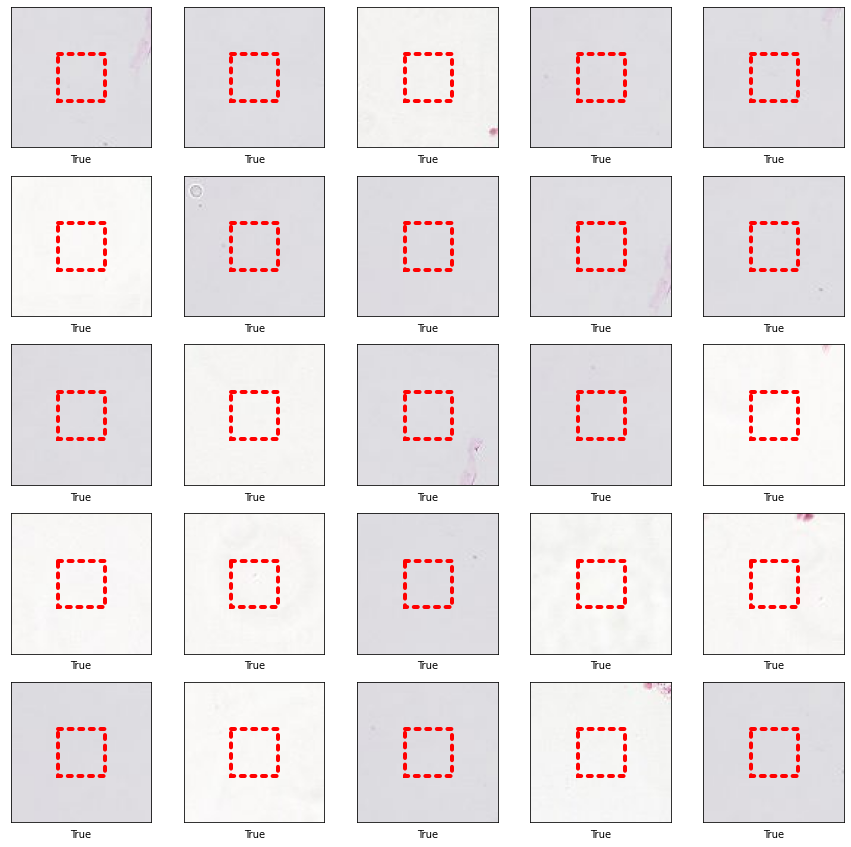

In [135]:
fig, ax = plt.subplots(5,5,figsize=(15,15))

shuffled_low_contrast = shuffle(y_to_plot[y_to_plot["is_low_contrast"] == True][ y_to_plot["translated_label"] == True])

for (i,current_subplot) in zip(range(25),ax.flat):
    current_row = shuffled_low_contrast.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    curr_file_path = current_row['file_name'].iloc[0]
    
    try:
        # read image and add to plot
        img = plt.imread(curr_file_path)
        current_subplot.imshow(img)
        
        current_label = current_row['translated_label'].iloc[0]
        
        if (current_label == True):
            current_patch_color = 'r'
        else:
            current_patch_color = 'b'
        
        # create patch recatangle around the suspected area
        box = patches.Rectangle((32,32),32,32, linewidth=4, edgecolor=current_patch_color, facecolor='none', linestyle=':', capstyle='round')
        
        # add labels and patch 
        current_subplot.xaxis.label.set_text(current_row['translated_label'].iloc[0])
        current_subplot.add_patch(box)
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

/Users/simonameriam/.conda/envs/data_sciense_keras_project/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


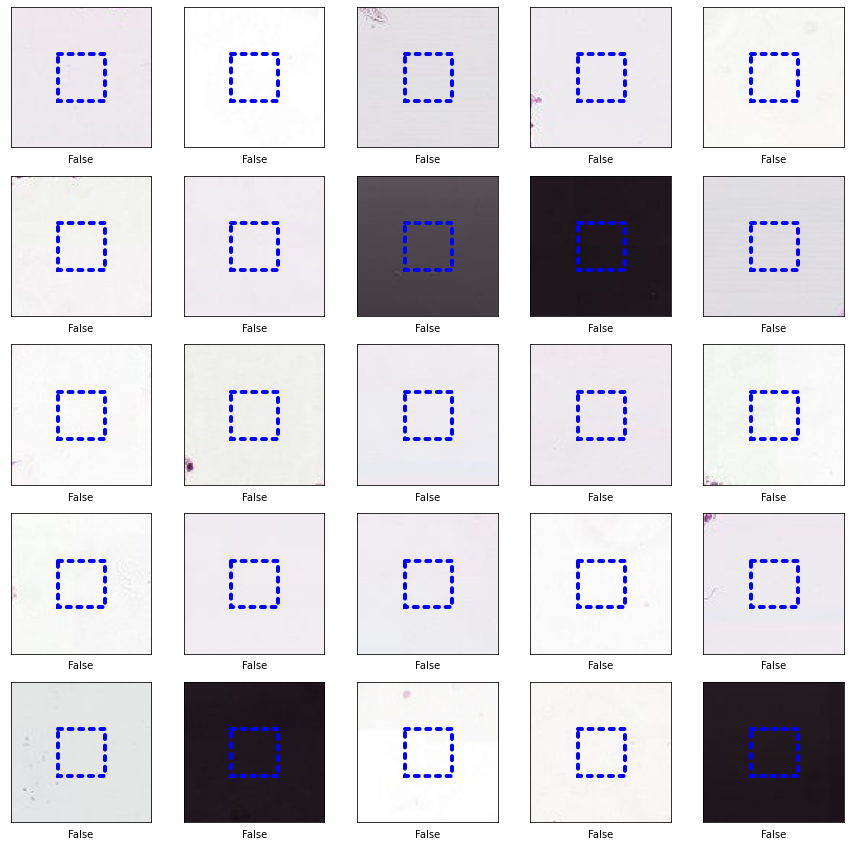

In [136]:
fig, ax = plt.subplots(5,5,figsize=(15,15))

shuffled_low_contrast = shuffle(y_to_plot[y_to_plot["is_low_contrast"] == True][ y_to_plot["translated_label"] == False])

for (i,current_subplot) in zip(range(25),ax.flat):
    current_row = shuffled_low_contrast.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    curr_file_path = current_row['file_name'].iloc[0]
    
    try:
        # read image and add to plot
        img = plt.imread(curr_file_path)
        current_subplot.imshow(img)
        
        current_label = current_row['translated_label'].iloc[0]
        
        if (current_label == True):
            current_patch_color = 'r'
        else:
            current_patch_color = 'b'
        
        # create patch recatangle around the suspected area
        box = patches.Rectangle((32,32),32,32, linewidth=4, edgecolor=current_patch_color, facecolor='none', linestyle=':', capstyle='round')
        
        # add labels and patch 
        current_subplot.xaxis.label.set_text(current_row['translated_label'].iloc[0])
        current_subplot.add_patch(box)
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

In general it looks like most of these images are very dark/very bright and there is nothing to the naked eye in the 32x32 diameter of the triangle. Not all images are single tone so let's get the threshold a little bit higher.

In [48]:
def is_low_contrast_func(file_name):
    return bool(is_low_contrast(plt.imread(file_name), fraction_threshold=0.005))

isLowContrastUDF = udf(lambda file_name: is_low_contrast_func(file_name),BooleanType())

y_low_contrast_df = y_trs_df.withColumn('is_low_contrast', isLowContrastUDF('file_name'))

y_low_contrast_df.persist()

y_low_contrast_df.show()

+--------------------+-----+----------------+--------------------+---------------+
|                  id|label|translated_label|           file_name|is_low_contrast|
+--------------------+-----+----------------+--------------------+---------------+
|00001b2b5609af42a...|    1|            true|../../data/histop...|          false|
|000020de2aa6193f4...|    0|           false|../../data/histop...|          false|
|00004aab08381d25d...|    0|           false|../../data/histop...|          false|
|0000d563d5cfafc4e...|    0|           false|../../data/histop...|          false|
|0000da768d06b879e...|    1|            true|../../data/histop...|          false|
|0000f8a4da4c286ee...|    0|           false|../../data/histop...|          false|
|00010f78ea8f87811...|    0|           false|../../data/histop...|          false|
|00011545a49581781...|    0|           false|../../data/histop...|          false|
|000126ec42770c756...|    0|           false|../../data/histop...|          false|
|000

In [49]:
y_to_plot = y_low_contrast_df.toPandas()

<AxesSubplot:xlabel='is_low_contrast', ylabel='count'>

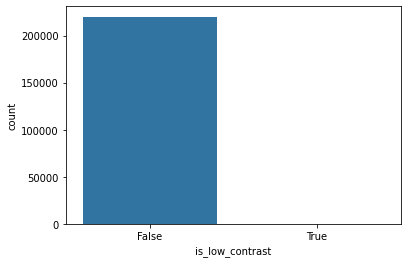

In [148]:
sns.countplot(data=y_to_plot, x='is_low_contrast')

In [149]:
y_to_plot[y_to_plot["is_low_contrast"] == True].groupby(['translated_label']).count()

,id,label,file_name,is_low_contrast
translated_label,,,,
False,17,17,17,17


So for the top threshold of 0.005 images we are left with 17 images all classified as False. Lets look at them

/Users/simonameriam/.conda/envs/data_sciense_keras_project/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


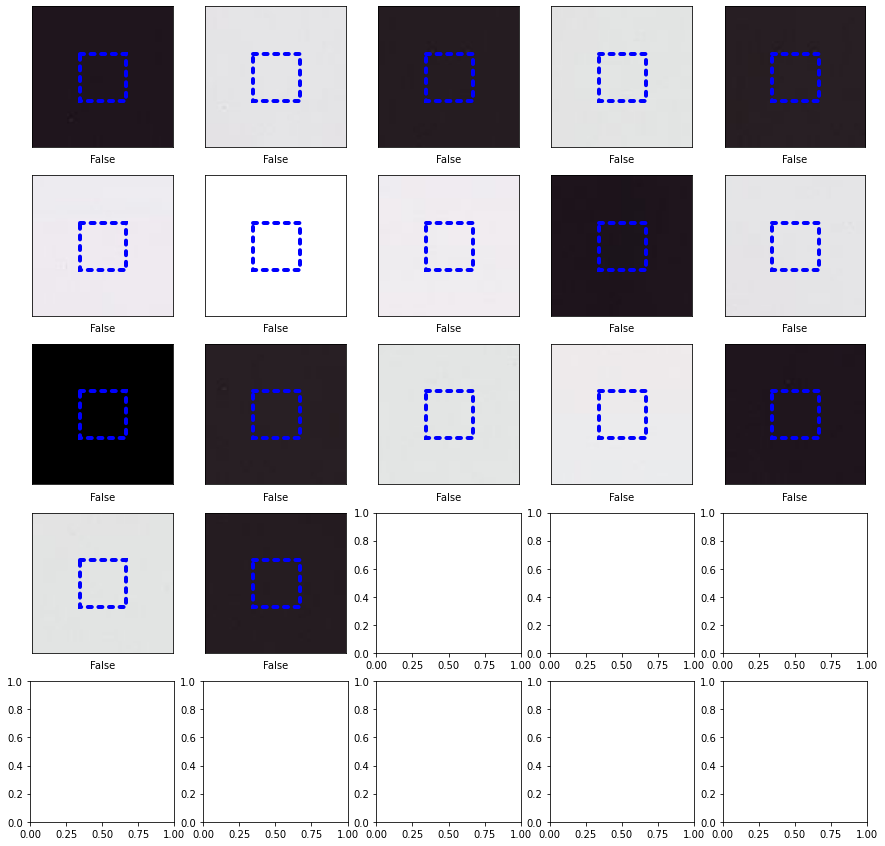

In [155]:
fig, ax = plt.subplots(5,5,figsize=(15,15))

shuffled_low_contrast = y_to_plot[y_to_plot["is_low_contrast"] == True][ y_to_plot["translated_label"] == False]

for (i,current_subplot) in zip(range(17),ax.flat):
    current_row = shuffled_low_contrast.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    curr_file_path = current_row['file_name'].iloc[0]
    
    try:
        # read image and add to plot
        img = plt.imread(curr_file_path)
        current_subplot.imshow(img)
        
        current_label = current_row['translated_label'].iloc[0]
        
        if (current_label == True):
            current_patch_color = 'r'
        else:
            current_patch_color = 'b'
        
        # create patch recatangle around the suspected area
        box = patches.Rectangle((32,32),32,32, linewidth=4, edgecolor=current_patch_color, facecolor='none', linestyle=':', capstyle='round')
        
        # add labels and patch 
        current_subplot.xaxis.label.set_text(current_row['translated_label'].iloc[0])
        current_subplot.add_patch(box)
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

It looks like all of these images are indeed very dark or very bright and don't represent actual cells or biopsies, we believe we can remove these.

In [50]:
cleaned_y_df = y_low_contrast_df.filter(col("is_low_contrast") == False)

In [38]:
cleaned_y_df.show()

+--------------------+-----+----------------+--------------------+---------------+
|                  id|label|translated_label|           file_name|is_low_contrast|
+--------------------+-----+----------------+--------------------+---------------+
|00001b2b5609af42a...|    1|            true|../../data/histop...|          false|
|000020de2aa6193f4...|    0|           false|../../data/histop...|          false|
|00004aab08381d25d...|    0|           false|../../data/histop...|          false|
|0000d563d5cfafc4e...|    0|           false|../../data/histop...|          false|
|0000da768d06b879e...|    1|            true|../../data/histop...|          false|
|0000f8a4da4c286ee...|    0|           false|../../data/histop...|          false|
|00010f78ea8f87811...|    0|           false|../../data/histop...|          false|
|00011545a49581781...|    0|           false|../../data/histop...|          false|
|000126ec42770c756...|    0|           false|../../data/histop...|          false|
|000

In [39]:
cleaned_y_df.groupBy("is_low_contrast").count().show()

+---------------+------+
|is_low_contrast| count|
+---------------+------+
|          false|220008|
+---------------+------+



In [51]:
y_to_plot = cleaned_y_df.toPandas()

<AxesSubplot:xlabel='translated_label', ylabel='count'>

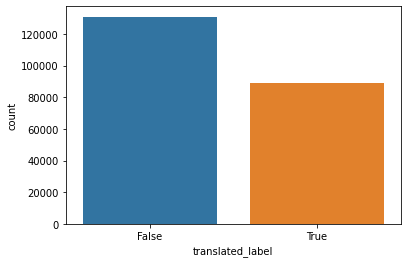

In [41]:
sns.countplot(data=y_to_plot, x='translated_label')

## Load image train set

#### Prepare dataframe for image gen loading

In [52]:
y_final_df = cleaned_y_df

In [53]:
model_df = y_final_df.withColumn('string_label',y_final_df['translated_label'].cast(StringType())).toPandas()

The data format we're dealing with here if tif. For this reason we can't use the image_dataset_from_directory provided by Keras. Instead we're going to use the ImageDataGenerator with

In [54]:
from keras.preprocessing.image import ImageDataGenerator

#### The image data generator is going to rescale the images, deviding them by 255 so that pixel value ranges between 0 and 1

In [55]:
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.3,
                             width_shift_range=4,  # randomly shift images horizontally
                             height_shift_range=4,  # randomly shift images vertically 
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=True)  # randomly flip image

In [56]:
batch_size=128

In [57]:
train_set = datagen.flow_from_dataframe(
        dataframe=model_df,
        x_col='file_name',
        y_col='string_label',
        shuffle=True,
        seed=42, 
        batch_size=batch_size,
        validation_split=0.3,
        subset="training",
        class_mode='binary',
        target_size=(96,96)) 



Found 154006 validated image filenames belonging to 2 classes.


In [58]:
val_set = datagen.flow_from_dataframe(
        dataframe=model_df,
        x_col='file_name',
        y_col='string_label',
        shuffle=True,
        seed=42,
        batch_size=batch_size,
        validation_split=0.3,
        subset="validation",
        class_mode='binary',
        target_size=(96,96)) 

Found 66002 validated image filenames belonging to 2 classes.


### Determining the size of the batch
So at this point we've actually got a pretty ugly exception if we'd set the batch size to be any number aside from 1. But then also not setting "steps_per_epoch" would put us in a bad position. 

Calculating the following metrics proves to be the same as len(train_set). So using this setting the "steps_per_epoch" is running a single image per set per the entire dataset. 

We then discovered that this exception was actually encountered because we didn't set the target_size=(96,96) in the previous section! We assumed that not setting target size would take the original image size, which is, (96,96). That assumption was clearly wrong.

In [59]:
train_steps_per_epoch = np.ceil(train_set.n / train_set.batch_size)
val_steps_per_epoch = np.ceil(val_set.n/ val_set.batch_size)

In [60]:
train_steps_per_epoch

1204.0

In [61]:
len(train_set)

1204

## Building our model

In [62]:
model = models.Sequential()
model.add(layers.Input(shape=(96, 96, 3)))

model.add(layers.Conv2D(16, (3, 3)))
model.add(layers.BatchNormalization(axis = 3))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization(axis = 3))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization(axis = 3))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

2022-06-14 22:42:14.382693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 94, 94, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 45, 45, 32)       1

## Compiling and fitting our model

In [64]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Notice no batch size and validation batch size are specified since our data is in the form of generator, and they already generate batches.

In [65]:
cnn_history = model.fit(train_set, epochs=5, steps_per_epoch=len(train_set),
                    validation_data=val_set,verbose=1)

Epoch 1/5
1204/1204 [==============================] - 1091s 905ms/step - loss: 0.4971 - accuracy: 0.7596 - val_loss: 0.4307 - val_accuracy: 0.8225
Epoch 2/5
1204/1204 [==============================] - 1266s 1s/step - loss: 0.4417 - accuracy: 0.7895 - val_loss: 0.4224 - val_accuracy: 0.8332
Epoch 3/5
1204/1204 [==============================] - 1195s 992ms/step - loss: 0.4283 - accuracy: 0.7977 - val_loss: 0.5610 - val_accuracy: 0.7816
Epoch 4/5
1204/1204 [==============================] - 1199s 996ms/step - loss: 0.4156 - accuracy: 0.8048 - val_loss: 0.5409 - val_accuracy: 0.8130
Epoch 5/5
1204/1204 [==============================] - 1120s 930ms/step - loss: 0.4053 - accuracy: 0.8114 - val_loss: 0.4444 - val_accuracy: 0.8207


Looking at the first epoch we've noticed the loss and accuracy don't really change afte raround 50-60K images

In [90]:
from tensorflow.keras.models import Sequential, save_model, load_model

In [92]:
# Save the model
filepath_cnn = './CNN_model'
save_model(model, filepath_cnn)

INFO:tensorflow:Assets written to: ./CNN_model/assets


INFO:tensorflow:Assets written to: ./CNN_model/assets


## Using DenseNet201 as model base

In [69]:
from tensorflow.keras.applications import DenseNet201

In [70]:
# We read that best practice for output dropout layer is 0.5 (0.5<x<0.8 for input layers)
dropout_factor = 0.5

In [71]:
## TODO: Check trainability of DenseNet201 since we're using image net weights here and these should be quite different for cancer
model_base = DenseNet201(input_shape=(96, 96, 3), include_top=False)
dense_net = models.Sequential()
dense_net.add(model_base)

dense_net.add(layers.Flatten())

dense_net.add(layers.Dense(64, activation='relu'))
dense_net.add(layers.Dropout(0.5))
dense_net.add(layers.Dense(1, activation='sigmoid'))

In [72]:
dense_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 3, 3, 1920)        18321984  
                                                                 
 flatten_1 (Flatten)         (None, 17280)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1105984   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19,428,033
Trainable params: 19,198,977
Non-trainable params: 229,056
_________________________________________________________________


In [73]:
dense_net.compile(optimizer=Adam(0.01),
              loss='binary_crossentropy',
              metrics=['accuracy','AUC'])

In [74]:
early_stopper = EarlyStopping(monitor='val_loss', patience=2, verbose=2, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [76]:
dense_history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_set, 
                    validation_steps=val_steps_per_epoch, 
                    callbacks=[early_stopper, reduce],
                    verbose=1)

Epoch 1/5
1204/1204 [==============================] - 1107s 920ms/step - loss: 0.3684 - accuracy: 0.8344 - val_loss: 0.3705 - val_accuracy: 0.8545 - lr: 0.0010
Epoch 2/5
1204/1204 [==============================] - 1369s 1s/step - loss: 0.3642 - accuracy: 0.8369 - val_loss: 0.3489 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 3/5
1204/1204 [==============================] - 1364s 1s/step - loss: 0.3569 - accuracy: 0.8424 - val_loss: 0.3124 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 4/5
1204/1204 [==============================] - ETA: 0s - loss: 0.3213 - accuracy: 0.8775
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1204/1204 [==============================] - 1365s 1s/step - loss: 0.3213 - accuracy: 0.8775 - val_loss: 0.3125 - val_accuracy: 0.8793 - lr: 0.0010
Epoch 5/5
1204/1204 [==============================] - 1366s 1s/step - loss: 0.2901 - accuracy: 0.8954 - val_loss: 0.2181 - val_accuracy: 0.9211 - lr: 1.0000e-04


In [114]:
# Save the model
filepath_dense = './Dense_model'
save_model(dense_net, filepath_dense)

INFO:tensorflow:Assets written to: ./Dense_model/assets


INFO:tensorflow:Assets written to: ./Dense_model/assets


In [84]:
def metrics_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1,len(acc)+1,1)

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Comparing the accuracy of two models

In [66]:
pd.DataFrame(cnn_history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.497053,0.759587,0.430738,0.822475
1,0.441725,0.789515,0.422426,0.833187
2,0.428256,0.797696,0.560955,0.781582
3,0.415641,0.804839,0.540915,0.813036
4,0.405254,0.811423,0.444430,0.820733


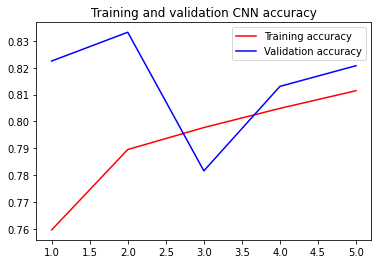

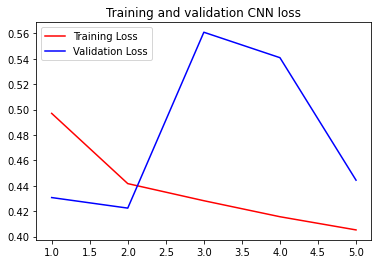

In [80]:
metrics_plot(cnn_history)

In [87]:
pd.DataFrame(dense_history.history)

,loss,accuracy,val_loss,val_accuracy,lr
0,0.368440,0.834364,0.370527,0.854489,0.0010
1,0.364202,0.836896,0.348922,0.867307,0.0010
2,0.356932,0.842363,0.312398,0.858323,0.0010
3,0.321258,0.877518,0.312470,0.879261,0.0010
4,0.290144,0.895446,0.218054,0.921108,0.0001


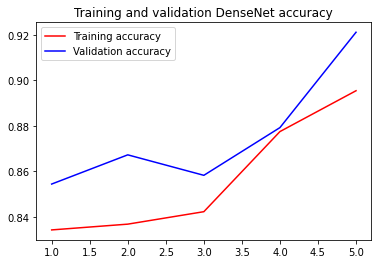

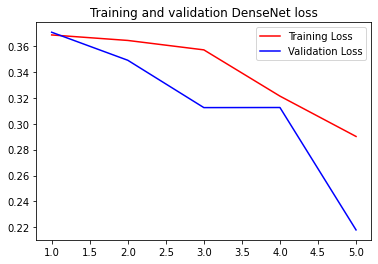

In [85]:
metrics_plot(dense_history)

Let's compare the accuracy of CNN model and DenseNet model.


At the moment our CNN model has an accuracy of ~85% on the training set and ~80% on the validation set. This means that we can expect our model to perform with ~80% accuracy on new data. On first two epochs our model accuracy metric increases on training set, while decreases on validation set. This means that our model is fitting the training set better, but is losing its ability to predict on new data, indicating that our model is starting to fit on noise and is beginning to overfit.But on the next epochs we see that accuracy of validation set is increasing. Still have to improve our model to get better accuracy and avoid the overfiting.

DenseNet model has an accuracy of ~89% on the training set and ~92% on validation set, it's much better than the CNN model. DenseNet model gives us higher accuracy on the validation set neither the training set. But the val_accuracy was getting higher only on two last epochs and got higher on ~15% than accuracy metric on first three epochs. On the third epoch we didn't get the accuracy of the validation set, because was no improvement since previous epoch.

In [88]:
from sklearn.metrics import confusion_matrix

In [115]:
#load the cnn and dense model
model_cnn = load_model(filepath_cnn, compile = True)
model_dense=load_model(filepath_dense,compile=True)

In [98]:
import matplotlib.pyplot as plt

In [112]:
predictions_cnn = model_cnn.predict_generator(val_set, verbose=1)

/var/folders/rz/mg07kb5d5sq7nxt3pjc8x1v13yjw0y/T/ipykernel_25734/35502877.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_cnn = model_cnn.predict_generator(val_set, verbose=1)


516/516 [==============================] - 267s 518ms/step


In [123]:
y_val_pred_cnn=np.round(predictions_cnn)

In [116]:
y_true = val_set.classes

In [119]:
predictions_dense=model_dense.predict_generator(val_set, verbose=1)

/var/folders/rz/mg07kb5d5sq7nxt3pjc8x1v13yjw0y/T/ipykernel_25734/3626107695.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_dense=model_dense.predict_generator(val_set, verbose=1)


516/516 [==============================] - 1514s 3s/step


In [122]:
y_val_pred_dense=np.round(predictions_dense)

In [124]:
confusion_cnn_mtx = confusion_matrix(y_true, y_val_pred_cnn)
confusion_dense_mtx = confusion_matrix(y_true,y_val_pred_dense)

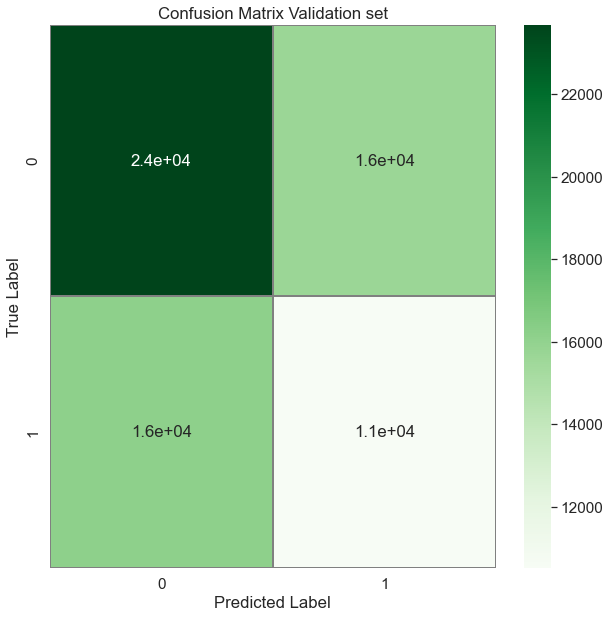

In [127]:
f,ax = plt.subplots(figsize=(10, 10))

sns.set(font_scale=1.4)
sns.heatmap(confusion_cnn_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Validation set")
plt.show()

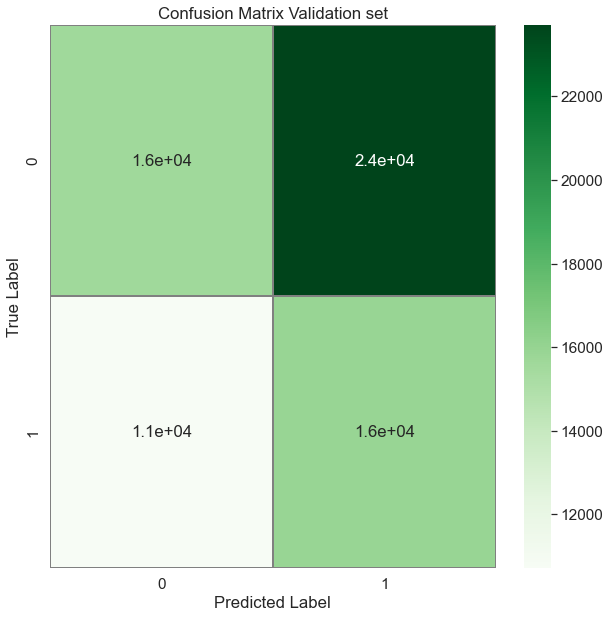

In [128]:
f,ax = plt.subplots(figsize=(10, 10))

sns.set(font_scale=1.4)
sns.heatmap(confusion_dense_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Validation set")
plt.show()

In [161]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from matplotlib import pyplot

In [149]:
print('Logistic: ROC AUC=%.3f' % (auc))

Logistic: ROC AUC=0.498


In [167]:
ns_probs = [0 for _ in range(len(y_true))]


In [168]:
ns_fpr_cnn, ns_tpr_cnn, _ = roc_curve(y_true, ns_probs)
lr_fpr_cnn, lr_tpr_cnn, _ = roc_curve(y_true, predictions_cnn)

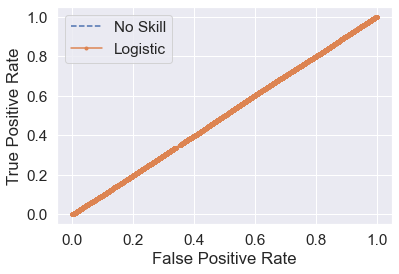

In [169]:
# plot the roc curve for the model
pyplot.plot(ns_fpr_cnn, ns_tpr_cnn, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_cnn, lr_tpr_cnn, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [163]:
ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_true, predictions_dense)


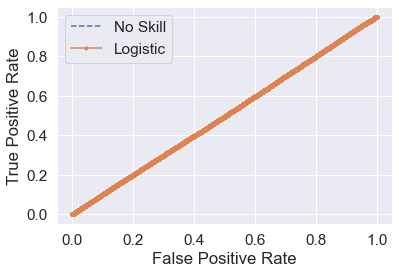

In [164]:
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Plans for the next month 

1) Improve our CNN model
2) Integrate the shap tool 
3) Fix bugs that related to image pixel values distribution
4) We were trying to use k-means clustering for image classification as well but faced the problem on splitting our data to train and test sets while using the sklearn function train_test_split. The problem is the shape of the data is to big (200250,96,96,3), our machines haven't not enough cores to process this amount of data. We were thinking to use cuda, maybe you can advise us better ways to do so or just decrease this amount for clustering part? Thanks in advance.